### STEP 1.  Load Data and Modules ; Define A Distance Helper Function

A list of specific pre-selected site IDs is loaded from the file covered_site_codes.txt.

The general database of information about the sites is loaded from measurements.csv (including the measurements themselves accessed by keying on the site IDs).  Data of the site locations (latitude and longitude) is loaded from stations.csv.

In [1]:
import pandas as pd
import numpy as np
import pickle
import math
import seaborn as sns

In [2]:
covered_site_codes_file="covered_site_codes.txt"
covered_site_codes=list()
with open(covered_site_codes_file) as reader:
    for csc in reader:
        covered_site_codes.append(csc.strip())
stations_df=pd.read_csv('stations.csv')
measurements_df=pd.read_csv('measurements.csv')
def getLLOfFromSID(sid):
    #get latitude and longitude from station id
    station_row=stations_df[stations_df['SITE_CODE']==sid]
    if(station_row.shape[0]!=1):
        raise Exception(f"invalid site code {sid}")
    slat=station_row['LATITUDE'].tolist()[0]
    slon=station_row['LONGITUDE'].tolist()[0]
    return [slat,slon]
site_lls=[getLLOfFromSID(site) for site in covered_site_codes]

### STEP 2.  Plot the Data ; The Water Measurements at the Sites and the Site Locations

Also, define some utility functions to create time series data to aid in the plotting.

/usr/local/lib/python3.8/dist-packages/geoplot/geoplot.py:885: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


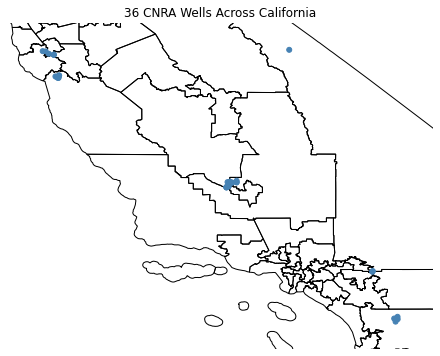

In [3]:
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Point
california = gpd.read_file(gplt.datasets.get_path('california_congressional_districts'))
sites_and_ll_df=pd.DataFrame.from_dict({
    'Site': covered_site_codes,
    'Latitude': [site_ll[0] for site_ll in site_lls],
    'Longitude': [site_ll[1] for site_ll in site_lls]
    })
gdf = gpd.GeoDataFrame(sites_and_ll_df, geometry=gpd.points_from_xy(sites_and_ll_df.Longitude, sites_and_ll_df.Latitude))
ax = gplt.polyplot(california)
gplt.pointplot(gdf, ax=ax)
the_title=plt.title("36 CNRA Wells Across California")

In [4]:
from datetime import datetime
def isYearALeapYear(y):
    m4=y%4
    #2020 is a leap year
    mr=2020%4
    if(mr==m4):
        #if 2020 and y are mod4 equivalent then y is a leap year
        return True
    else:
        return False
def getFirstDayOfMonth(m):
    return 1


def getLastDayOfMonth(m,y):
    #1-based indexing !
    #31-day months
    toms=[1,3,5,7,8,10,12]
    #30-day months
    tms=[4,6,9,11]
    if(m in toms):
        return 31
    elif(m in tms):
        return 30
    elif(m==2):
        isLeap=isYearALeapYear(y)
        if(isLeap):
            return 29
        else:
            return 28
    else:
        raise Exception(f"Unknown month {m} ; month is 1-based indexing!")
def generatePickleRanges():
    start_p_year=2003
    end_p_year=2016
    pkl_yrs=range(start_p_year,end_p_year+1)
    pkl_mons=range(1,12+1)
    pickle_starts=list()
    pickle_ends=list()
    for pickle_year in pkl_yrs:
        for pickle_month in pkl_mons:
            first_day=getFirstDayOfMonth(pickle_month)
            last_day=getLastDayOfMonth(pickle_month,pickle_year)
            f_dto=datetime(pickle_year, pickle_month, first_day)
            l_dto=datetime(pickle_year, pickle_month, last_day,
                                    hour=23, minute=59, second=59, microsecond=999999)
            pickle_starts.append(f_dto)
            pickle_ends.append(l_dto)
    return [pickle_starts,pickle_ends]
pickle_ranges=generatePickleRanges()


def isThisDTOInRange(dto,start_range,end_range):
    if(start_range<=dto and dto<=end_range):
        return True
    return False


def convertMeasDataToDTO(md):
    #2009-05-01 00:00:00
    #'Jun 1 2005  1:33PM', '%b %d %Y %I:%M%p')
    datetime_object=None
    try:
        datetime_object = datetime.strptime(md,'%Y-%m-%d %H:%M:%S')
    except ValueError:
        datetime_object = datetime.strptime(md,'%Y-%m-%d')
    return datetime_object

In [5]:
def getSCTimeSeries(site_code,pickle_ranges):
    pickle_ranges_starts=pickle_ranges[0]
    pickle_ranges_ends=pickle_ranges[1]
    sc_rows=measurements_df[measurements_df['SITE_CODE']==site_code]
    sc_rows.reset_index(drop=True,inplace=True)
    monthly_means=list()
    for p in range(len(pickle_ranges_starts)):
        rows_to_get_avg_of=sc_rows[sc_rows.apply(lambda row:isThisDTOInRange(convertMeasDataToDTO(row['MSMT_DATE']),pickle_ranges_starts[p],pickle_ranges_ends[p]),axis=1)]
        monthly_mean=np.mean(rows_to_get_avg_of['GSE_GWE'].tolist())
        if(np.isnan(monthly_mean)):
            print(f"For {site_code}  month {pickle_ranges_starts[p]}, the mean is {monthly_mean} from {rows_to_get_avg_of['GSE_GWE'].tolist()}!")
        monthly_means.append(monthly_mean)
    return monthly_means    

import matplotlib.pyplot as plt

def plotSiteCodeAndNearestPkl(site_code,pickle_ranges):
    #https://stackoverflow.com/questions/22276066/how-to-plot-multiple-functions-on-the-same-figure-in-matplotlib
    t=range(168)
    sc_ts=getSCTimeSeries(site_code,pickle_ranges)
    site_code_ll=getLLOfFromSID(site_code)
    plt.plot(t, sc_ts, 'r')
    site_ll=getLLOfFromSID(site_code)
    plt.title(f"Site Code :{site_code} : {round(site_ll[0],2)},{round(site_ll[1],2)}")
    plt.show()

Plotting 352958N1193011W001


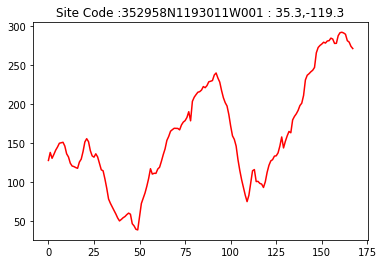

Plotting 369616N1218787W001


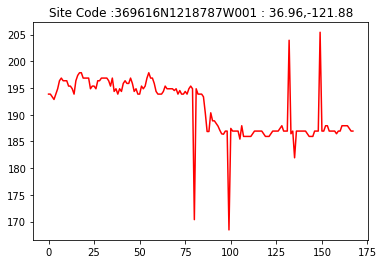

Plotting 369633N1218694W001


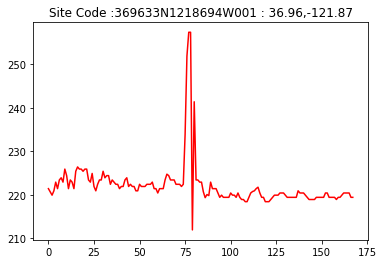

Plotting 369857N1219170W001


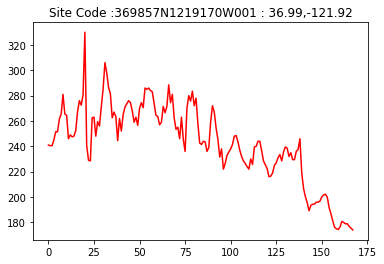

Plotting 372361N1217940W001


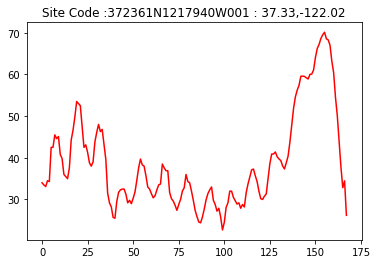

Plotting 352895N1193032W002


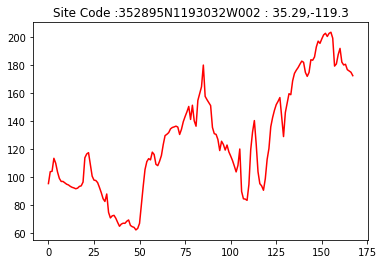

Plotting 352895N1193032W001


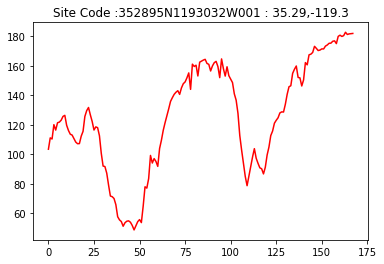

Plotting 352895N1193032W003


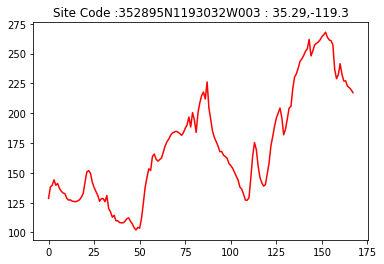

Plotting 369786N1219031W001


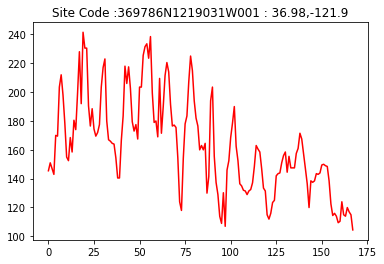

Plotting 353037N1192699W002


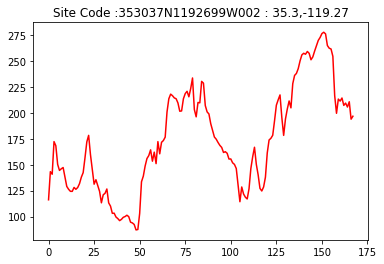

Plotting 353037N1192699W001


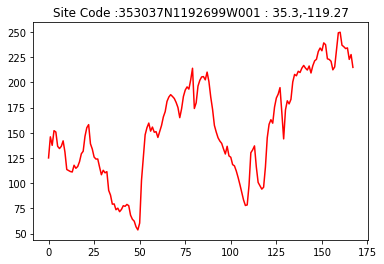

Plotting 369996N1218612W001


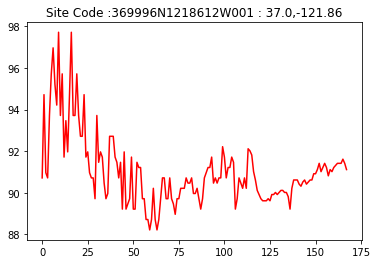

Plotting 373922N1183430W001


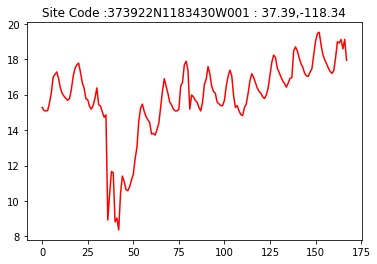

Plotting 370000N1218609W001


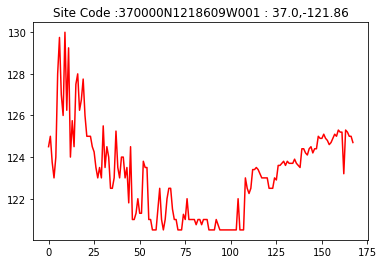

Plotting 333103N1166879W001


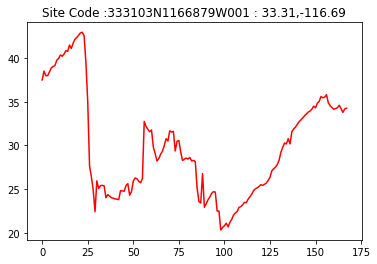

Plotting 332839N1167395W001


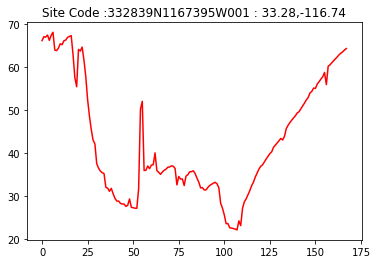

Plotting 332867N1167043W001


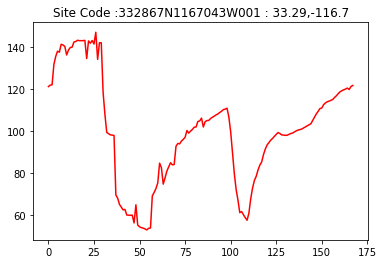

Plotting 332367N1167165W001


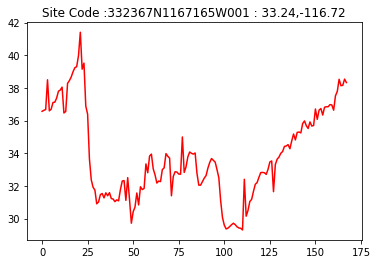

Plotting 332742N1166846W001


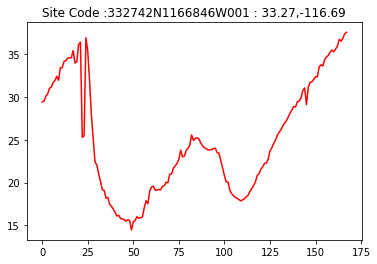

Plotting 353620N1191457W001


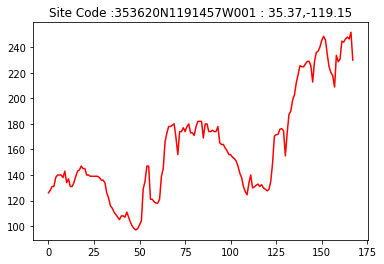

Plotting 353620N1191457W002


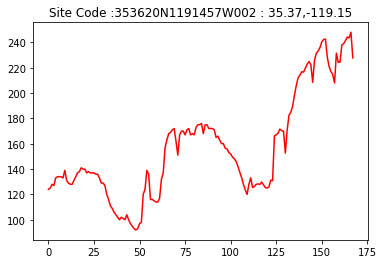

Plotting 353760N1192498W001


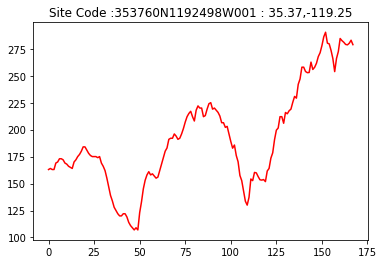

Plotting 353760N1192498W002


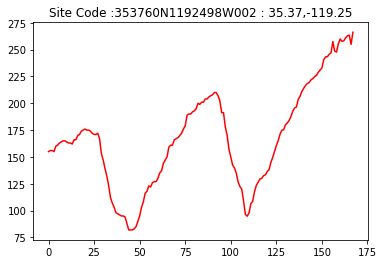

Plotting 353618N1192169W001


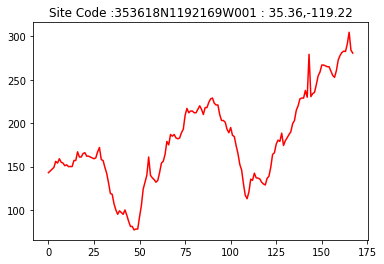

Plotting 353618N1192169W002


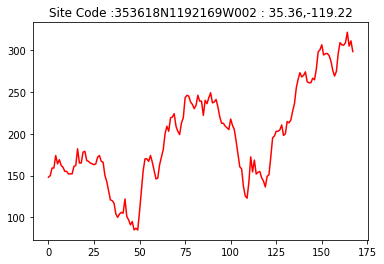

Plotting 340090N1170648W001


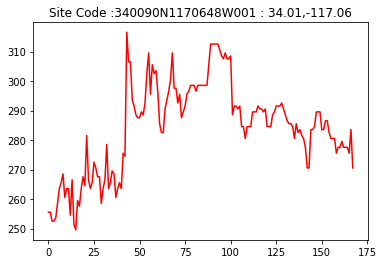

Plotting 340009N1170735W001


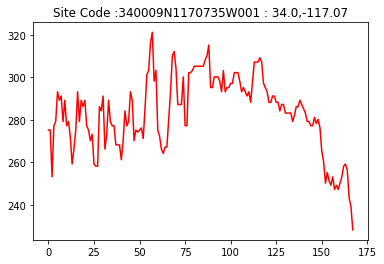

Plotting 340033N1170693W001


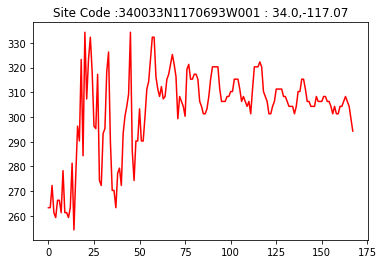

Plotting 353890N1191471W001


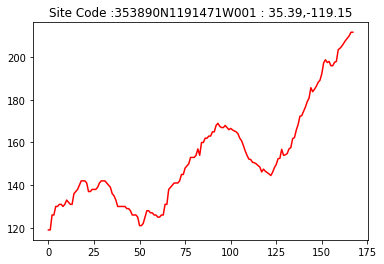

Plotting 353693N1192870W001


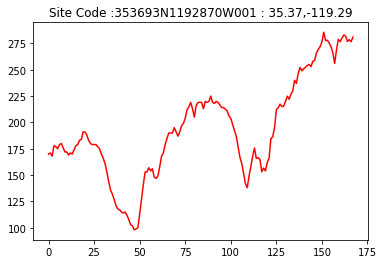

Plotting 369760N1218695W001


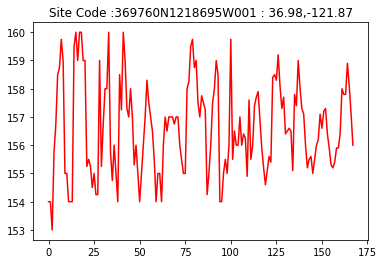

Plotting 373177N1219435W001


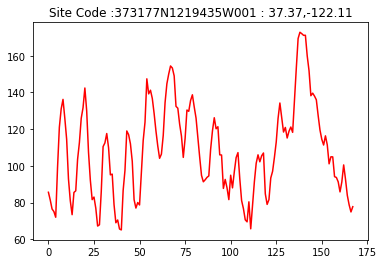

Plotting 373177N1219435W002


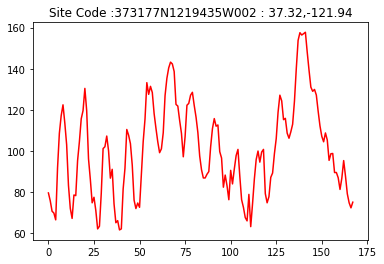

Plotting 373177N1219435W003


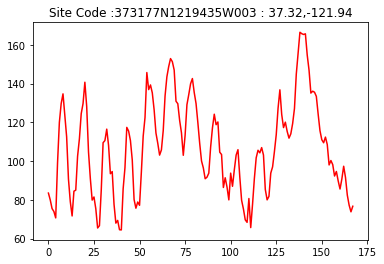

Plotting 373177N1219435W004


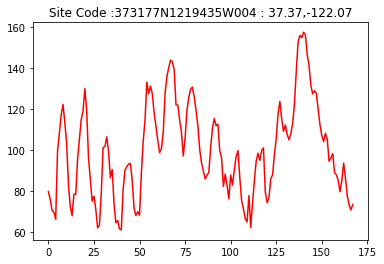

Plotting 373177N1219435W005


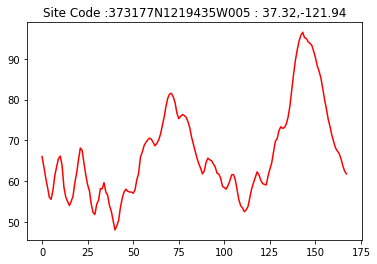

In [6]:
for site_code in covered_site_codes:
    print(f"Plotting {site_code}")
    plotSiteCodeAndNearestPkl(site_code,pickle_ranges)

### STEP 3.  Based on the plots above, select a handful of repressentative sites ; plot these again

4 sites are chosen and they are re-plotted below.  Selections are based on two things:

1. their locations in the state,
2. how the curves themselves are representative of other curves in that cluster.   This decision was made admittedly a bit subjectively by "eyeballing" the curves and selcting curves which seemed to be like other curves.  The selected curves also are not the noisiest.  The noisiest curves have many little spikes/peaks, but the selected plots have peaks which are wider.

Plotting 373177N1219435W005


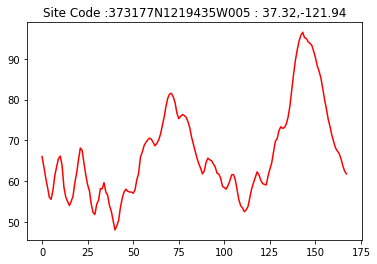

Plotting 353890N1191471W001


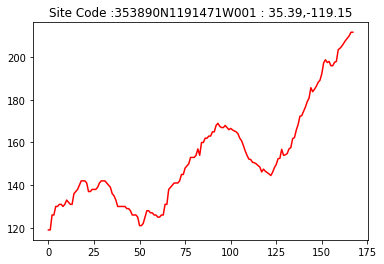

Plotting 373922N1183430W001


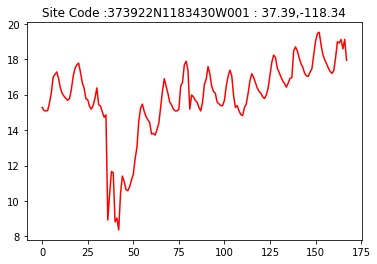

Plotting 340033N1170693W001


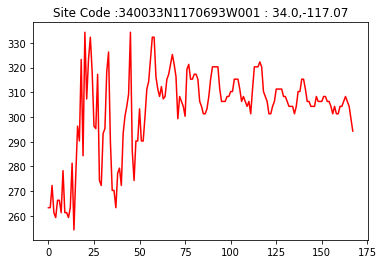

In [7]:
to_model=["373177N1219435W005","353890N1191471W001","373922N1183430W001","340033N1170693W001"]
for site_code in to_model:
    print(f"Plotting {site_code}")
    plotSiteCodeAndNearestPkl(site_code,pickle_ranges)

/usr/local/lib/python3.8/dist-packages/geoplot/geoplot.py:885: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


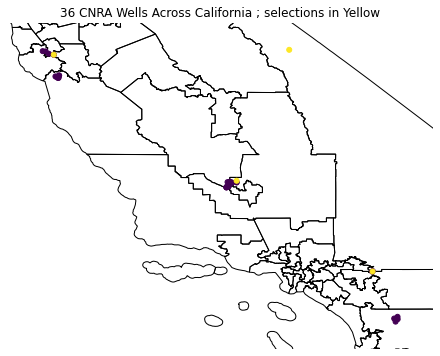

In [8]:
california = gpd.read_file(gplt.datasets.get_path('california_congressional_districts'))
#california = gpd.read_file(gplt.datasets.get_path('california_state'))
sites_and_ll_df=pd.DataFrame.from_dict({
    'Site': covered_site_codes,
    'Latitude': [site_ll[0] for site_ll in site_lls],
    'Longitude': [site_ll[1] for site_ll in site_lls],
    'MStatus' : [site in to_model for site in covered_site_codes]
    })
gdf = gpd.GeoDataFrame(sites_and_ll_df, geometry=gpd.points_from_xy(sites_and_ll_df.Longitude, sites_and_ll_df.Latitude))
ax = gplt.polyplot(california)
gplt.pointplot(gdf, ax=ax,hue='MStatus')
the_title=plt.title(f"{len(covered_site_codes)} CNRA Wells Across California ; selections in Yellow")

### STEP 4.  Write the selected data to a directory for subsequent ARIMA analysis

In [9]:
cnra_dir="./CNRA_data/"
import os
if(not(os.path.exists(cnra_dir))):
    os.mkdir(cnra_dir)
for site_code in to_model:
    file_to_write=cnra_dir+site_code+".csv"
    sc_ts=getSCTimeSeries(site_code,pickle_ranges)
    temp_df_dict=dict()
    temp_df_dict[site_code]=sc_ts
    temp_df=pd.DataFrame.from_dict(temp_df_dict)
    temp_df.to_csv(file_to_write,index=False)
    print(f"Wrote data for {site_code} to {file_to_write}")

Wrote data for 373177N1219435W005 to ./CNRA_data/373177N1219435W005.csv
Wrote data for 353890N1191471W001 to ./CNRA_data/353890N1191471W001.csv
Wrote data for 373922N1183430W001 to ./CNRA_data/373922N1183430W001.csv
Wrote data for 340033N1170693W001 to ./CNRA_data/340033N1170693W001.csv
